# Link prediction
In this notebook, we'll formulate a machine learning problem to predict desiccation edges in the future.

In [35]:
import networkx as nx
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from statistics import median
from itertools import combinations
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

## Read in data

In [36]:
graph = nx.read_graphml('../data/kg/all_drought_dt_co_occurrence_graph_29Apr2024.graphml')

## Formulation of ML problem
We want to predict desiccation edges that appear in the future of the graph. In order to prevent data leakage, we'll formulate this problem as predicting just edges that appear in the next year. We can then string together sets of predictions to perform forecasting farther into the future.

Starting in 2015, we'll slice the graph for each year. The training data will be taken from the 2015-2019 slices of the graph, while the testing data will be taken from the 2020-2023 slices of the graph. We'll train one model on the 2015-2019 model, and then test on the data from 2020-2023.

## Explore network-based features for ML prediction
What kind of information does this graph contain that would help us make predictions of new edges that are desiccaion-related?

We're going to be taking random pairs of nodes and asking the model to say whether or not there will be an edge between them at some point in the future. So for each node in the pair, we could use these features:
* Node degree
* Number of doc mentions for node
* Node degree * number of doc mentions for all edges
* Entity type
* Proportion of edges for each node that are desiccation or drought
* Rate of edge addition for each node (using first year of mention)

We've already looked at some of these in our graph exploration (degree and weight), but what do the distribution of types, edge type proportions and rate of new edge addition look like?

### Entity type distribution

In [37]:
ent_types = defaultdict(int)
for n, attrs in graph.nodes(data=True):
    ent_types[attrs['ent_type']] += 1

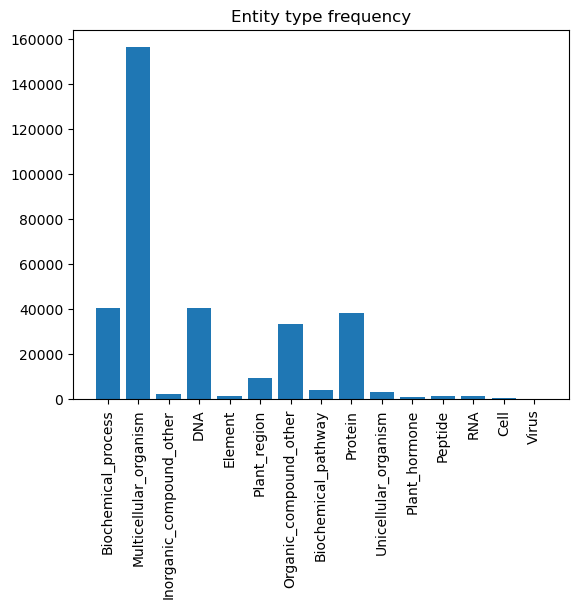

In [38]:
_ = plt.bar(ent_types.keys(), ent_types.values())
_ = plt.xticks(rotation=90)
_ = plt.title('Entity type frequency')

### Edge proportions
For the edge proportions, we're going to calculate $\frac{\text{Edges with } \textit{is_desiccation}}{\text{Node degree}}$, ignoring whether or not the edge is also labeled as being drought.

In [39]:
node_des_edge_counts = defaultdict(int)
node_degrees = graph.degree()
for e1, e2, attrs in graph.edges(data=True):
    if attrs['is_desiccation']:
        node_des_edge_counts[e1] += 1
        node_des_edge_counts[e2] += 1
edge_props = []
for n in graph.nodes:
    try:
        p = node_des_edge_counts[n]/node_degrees[n]
        edge_props.append(p)
    except ZeroDivisionError:
        edge_props.append(0)

Text(0.5, 0.98, 'Distribution of desiccation edge proportion')

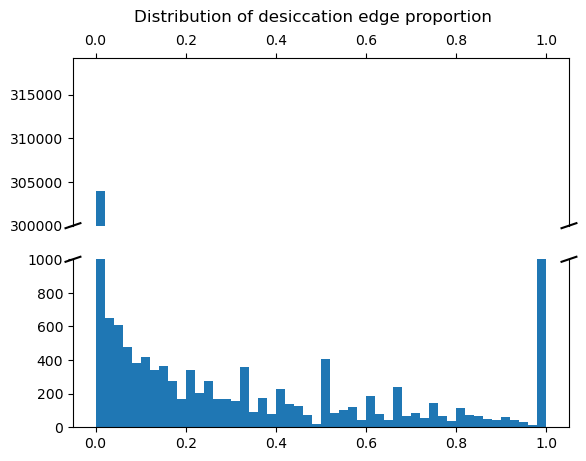

In [40]:
# Code from https://matplotlib.org/2.0.2/examples/pylab_examples/broken_axis.html
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

_ = ax1.hist(edge_props, bins=50)
_ = ax2.hist(edge_props, bins=50)

# Get max y-value
maxy = ax1.get_ylim()[1]
basemax = plt.yticks()[0][-2]

# Set the y limits
ax1.set_ylim(basemax, maxy)
ax2.set_ylim(0, 1000) # Got by trial end error

# Finish formatting
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Add the cut diagonals
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

fig.suptitle('Distribution of desiccation edge proportion')

What if we only consider edsiccation-only edges, as opposed to any that are labeled as desiccation?

In [41]:
node_des_only_edge_counts = defaultdict(int)
for e1, e2, attrs in graph.edges(data=True):
    if attrs['is_desiccation']:
        if not attrs['is_drought']:
            node_des_only_edge_counts[e1] += 1
            node_des_only_edge_counts[e2] += 1
edge_props_only = []
for n in graph.nodes:
    try:
        p = node_des_only_edge_counts[n]/node_degrees[n]
        edge_props_only.append(p)
    except ZeroDivisionError:
        continue

Text(0.5, 0.98, 'Distribution of desiccation-only edge proportion')

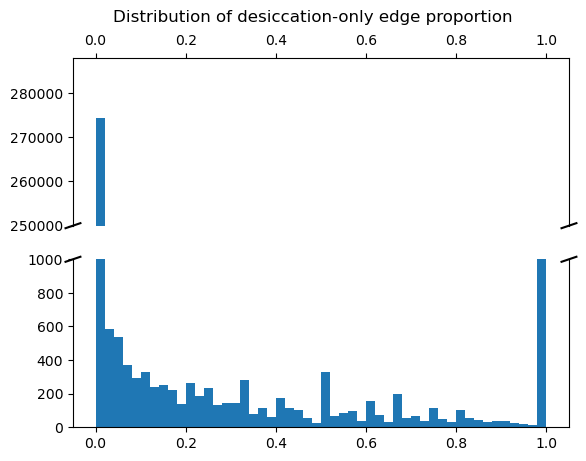

In [42]:
# Code from https://matplotlib.org/2.0.2/examples/pylab_examples/broken_axis.html
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

_ = ax1.hist(edge_props_only, bins=50)
_ = ax2.hist(edge_props_only, bins=50)

# Get max y-value
maxy = ax1.get_ylim()[1]
basemax = plt.yticks()[0][-2]

# Set the y limits
ax1.set_ylim(basemax, maxy)
ax2.set_ylim(0, 1000) # Got by trial end error

# Finish formatting
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Add the cut diagonals
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

fig.suptitle('Distribution of desiccation-only edge proportion')

These are different, but not so much that's it's obvious from looking at the plots. The excellent news is that there's a pretty good distribution between 0 and 1 here.

### Rate of edge addition
This one isn't a static feature, so it's a little trickier. For starters, I'll calculate the average number of new edges added per year (starting from the earliest year for the edges of that node), and also use the median edge year as a feature.

In [43]:
years_added = defaultdict(list)
for e1, e2, attrs in graph.edges(data=True):
    years_added[e1].append(int(attrs['first_year_mentioned']))
    years_added[e2].append(int(attrs['first_year_mentioned']))
avg_rate = []
median_year = []
for n, years in years_added.items():
    counted = Counter(years)
    avg_rate.append(sum(counted.values())/len(counted))
    median_year.append(median(years))

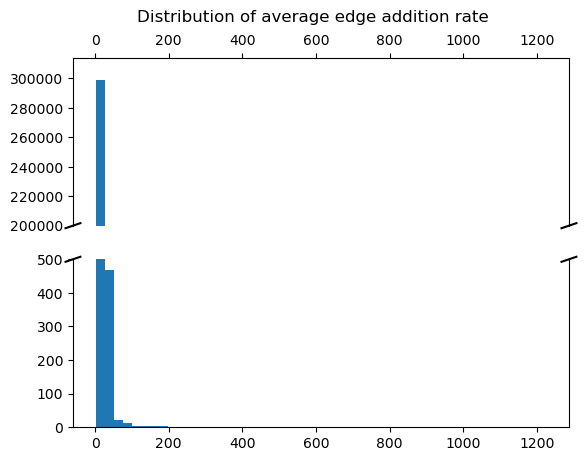

In [44]:
# Code from https://matplotlib.org/2.0.2/examples/pylab_examples/broken_axis.html
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

_ = ax1.hist(avg_rate, bins=50)
_ = ax2.hist(avg_rate, bins=50)

# Get max y-value
maxy = ax1.get_ylim()[1]
basemax = plt.yticks()[0][-3]

# Set the y limits
ax1.set_ylim(basemax, maxy)
ax2.set_ylim(0, 500) # Got by trial end error

# Finish formatting
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# Add the cut diagonals
d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

_ = fig.suptitle('Distribution of average edge addition rate')

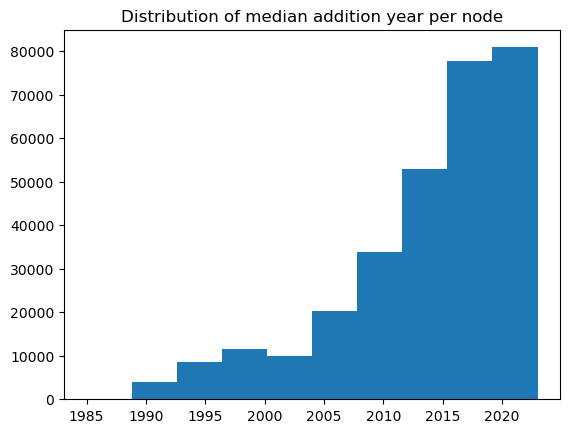

In [45]:
_ = plt.hist(median_year)
_ = plt.title('Distribution of median addition year per node')

## Build feature table
Let's implement code to build a feature table containing each pair of nodes. We can split the table into train/test based on year, and then downsample the negative instances to balance the sets.

### Code

In [46]:
test_nodes = [('n1', {'is_drought': True, 'is_desiccation': True, 'first_year_mentioned': 1998, 'num_doc_mentions_all_time': 5, 'ent_type': 'Multicellular_organism'}),
              ('n2', {'is_drought': True, 'is_desiccation': False, 'first_year_mentioned': 1999, 'num_doc_mentions_all_time': 1, 'ent_type': 'Multicellular_organism'}),
              ('n3', {'is_drought': False, 'is_desiccation': True, 'first_year_mentioned': 1998, 'num_doc_mentions_all_time': 8, 'ent_type': 'Multicellular_organism'}),
              ('n4', {'is_drought': True, 'is_desiccation': True, 'first_year_mentioned': 1997, 'num_doc_mentions_all_time': 15, 'ent_type': 'Multicellular_organism'}),
              ('n5', {'is_drought': False, 'is_desiccation': True, 'first_year_mentioned': 2017, 'num_doc_mentions_all_time': 21, 'ent_type': 'Multicellular_organism'}),
              ('n6', {'is_drought': True, 'is_desiccation': True, 'first_year_mentioned': 2004, 'num_doc_mentions_all_time': 82, 'ent_type': 'Multicellular_organism'}),
             ('n7', {'is_drought': True, 'is_desiccation': False, 'first_year_mentioned': 2015, 'num_doc_mentions_all_time': 32, 'ent_type': 'Multicellular_organism'}),
             ('n8', {'is_drought': False, 'is_desiccation': True, 'first_year_mentioned': 2009, 'num_doc_mentions_all_time': 29, 'ent_type': 'Multicellular_organism'})]
test_edges = [
    ('n1', 'n2', {'is_desiccation': True, 'is_drought': True, 'first_year_mentioned': 1999, 'num_doc_mentions_all_time': 51}),
    ('n3', 'n2', {'is_desiccation': False, 'is_drought': True, 'first_year_mentioned': 2008, 'num_doc_mentions_all_time': 65}),
    ('n1', 'n3', {'is_desiccation': True, 'is_drought': False, 'first_year_mentioned': 1998, 'num_doc_mentions_all_time': 23}),
    ('n5', 'n4', {'is_desiccation': True, 'is_drought': False, 'first_year_mentioned': 2017, 'num_doc_mentions_all_time': 45}),
    ('n1', 'n5', {'is_desiccation': True, 'is_drought': True, 'first_year_mentioned': 2020, 'num_doc_mentions_all_time': 12}),
    ('n6', 'n8', {'is_desiccation': True, 'is_drought': True, 'first_year_mentioned': 2012, 'num_doc_mentions_all_time': 122}),
    ('n8', 'n7', {'is_desiccation': True, 'is_drought': True, 'first_year_mentioned': 2022, 'num_doc_mentions_all_time': 12}),
    ('n6', 'n1', {'is_desiccation': True, 'is_drought': True, 'first_year_mentioned': 2005, 'num_doc_mentions_all_time': 12})
]

unit_test_graph = nx.Graph()
_ = unit_test_graph.add_nodes_from(test_nodes)
_ = unit_test_graph.add_edges_from(test_edges)

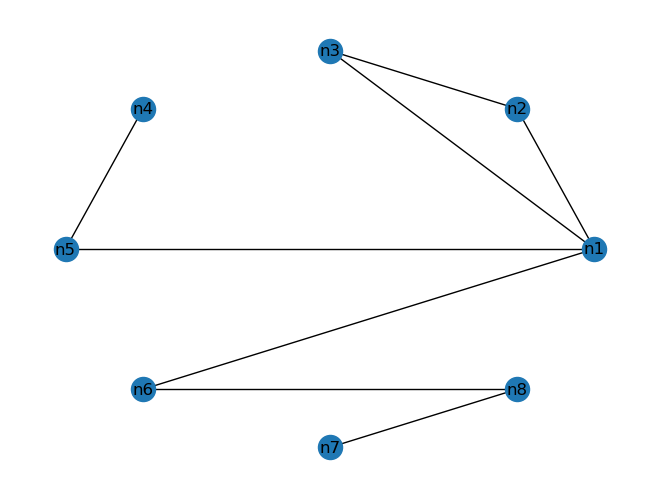

In [47]:
layout = nx.circular_layout(unit_test_graph)
nx.draw(unit_test_graph, pos=layout, with_labels=True)

In [48]:
def get_paired_features(pair_names, edges, per_node_features):
    """
    Get node pair features.
    """
    all_paired_features = {}
    for n1, n2 in pair_names:
        pair_features = {}
        # Check if it's an edge
        if ((n1, n2) in edges.keys()) or ((n2, n1) in edges.keys()):
            is_edge = True
            try:
                edge_attrs = edges[(n1, n2)]
                key_order = (n1, n2)
            except KeyError:
                edge_attrs = edges[(n2, n1)]
                key_order = (n2, n1)
        else:
            is_edge = False
            key_order = (n1, n2)
        # Merge the attributes for the individual nodes
        for k, v in per_node_features[n1].items():
            pair_features[f'{k}_n1'] = v
        for k, v in per_node_features[n2].items():
            pair_features[f'{k}_n2'] = v
        # Add composite features/labels
        if is_edge:
            pair_features['are_connected'] = True
            if edge_attrs['is_drought']:
                pair_features['is_drought_edge'] = True
                if edge_attrs['is_desiccation']:
                    pair_features['is_desiccation_edge'] = True
                else:
                    pair_features['is_desiccation_edge'] = False
            else:
                pair_features['is_drought_edge'] = False
                if edge_attrs['is_desiccation']:
                    pair_features['is_desiccation_edge'] = True
                else:
                    pair_features['is_desiccation_edge'] = False
            pair_features['year_first_connected'] = edge_attrs['first_year_mentioned']
        else:
            pair_features['are_connected'] = False
            pair_features['is_drought_edge'] = False
            pair_features['is_desiccation_edge'] = False
        all_paired_features[key_order] = pair_features
        
    return all_paired_features

In [49]:
def get_node_features(graph, cut_years):
    """
    Get the per-node features for each year's instances.
    """
    year_per_node_features = {}
    year_graphs = {}
    for cut_year in cut_years:
        # Get rid of anything after the cut year in the graph
        pre_cutoff_graph = nx.Graph()
        new_nodes = [(n, attrs) for n, attrs in graph.nodes(data=True)
                               if int(attrs['first_year_mentioned']) < cut_year]
        new_edges = [(e1, e2, attrs) for e1, e2, attrs in graph.edges(data=True)
                               if int(attrs['first_year_mentioned']) < cut_year]
        _ = pre_cutoff_graph.add_nodes_from(new_nodes)
        _ = pre_cutoff_graph.add_edges_from(new_edges)
        year_graphs[cut_year] = pre_cutoff_graph
    
        # Get the features for each node
        per_node_features = defaultdict(dict)

        # Degree
        g_degree = pre_cutoff_graph.degree()
        for n, deg in g_degree:
            per_node_features[n]['degree'] = deg

        # Entity type, year, number of node mentions
        for n, attrs in pre_cutoff_graph.nodes(data=True):
            per_node_features[n]['ent_type'] = attrs['ent_type']
            per_node_features[n]['node_year_first_mentioned'] = attrs['first_year_mentioned']

        # Edge-based feature basics
        years_added = defaultdict(list)
        node_des_only_edge_counts = defaultdict(int)
        for e1, e2, attrs in tqdm(pre_cutoff_graph.edges(data=True)):
            # Years
            years_added[e1].append(int(attrs['first_year_mentioned']))
            years_added[e2].append(int(attrs['first_year_mentioned']))
            # Counts for edge proportion
            if attrs['is_desiccation']:
                if not attrs['is_drought']:
                    node_des_only_edge_counts[e1] += 1
                    node_des_only_edge_counts[e2] += 1
        
        # Process edge based features
        for n in pre_cutoff_graph.nodes:
            # Years
            try:
                years = years_added[n]
                counted = Counter(years)
                per_node_features[n]['avg_year_additions'] = sum(counted.values())/len(counted)
                per_node_features[n]['median_year_added'] = median(years)
            except ZeroDivisionError:
                per_node_features[n]['avg_year_additions'] = 0
                per_node_features[n]['median_year_added'] = 0
            # Edge proportion
            try:
                des_count = node_des_only_edge_counts[n]
                per_node_features[n]['des_only_prop'] = des_count/g_degree[n]
            except ZeroDivisionError:
                per_node_features[n]['des_only_prop'] = 0
        year_per_node_features[cut_year] = per_node_features
        
    return year_per_node_features, year_graphs

In [50]:
def get_positive_and_negative_pairs(graph, cut_years):
    """
    Get the pair names for positive and negative instances. Negative instances are negative over all time (for which
    the graph contains data), but are balanced for each year and only contain feature information for the same time
    period as the positive instances for that year.
    """
    positives = {}
    negatives = {}
    all_negative_names = []
    node_years = nx.get_node_attributes(graph, 'first_year_mentioned')
    for cut_year in cut_years:
        
        # Get positive instances, which are edges added in the cut year
        positive_pair_names = [(e1, e2) for e1, e2, attrs in graph.edges(data=True)
                               if attrs['is_desiccation'] and (int(attrs['first_year_mentioned']) == cut_year)]
        positive_pair_names = [pair for pair in positive_pair_names if (int(node_years[pair[0]]) < cut_year)
                              and (int(node_years[pair[1]]) < cut_year)]
        print(f'There are {len(positive_pair_names)} positive pairs for year {cut_year}.')
        
        # Get negative instances, which are pairs of nodes that never get an edge
        negative_pair_candidates = combinations(list(graph.nodes), 2)
        negative_pair_names = []
        for pair in negative_pair_candidates:
            if len(negative_pair_names) == len(positive_pair_names):
                break
            else:
                if not graph.has_edge(pair[0], pair[1]): # If they're never connected
                    if pair not in all_negative_names: # And it's not already a negative
                        if (int(node_years[pair[0]]) < cut_year) and (int(node_years[pair[1]]) < cut_year): # And the nodes exist prior to this year
                            negative_pair_names.append(pair) # Add it as a negative
                            all_negative_names.append(pair)
        print(f'A corresponding {len(negative_pair_names)} negative instances have been constructed for year {cut_year}.')
    
        # Add to the dictionaries for the year
        positives[cut_year] = positive_pair_names
        negatives[cut_year] = negative_pair_names
        
    return positives, negatives

In [51]:
def build_feature_table(graph, cut_years=[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023], test_cutoff=2020):
    """
    Build the feature table. Current features are:
        Node degree
        Entity type
        Proportion of edges for each node that are desiccation or drought
        Rate of edge addition for each node (using first year of mention)
        Whether or not the other two nodes are already connected by a drought edge
    """
    # Get the pair names for positive and negative instances from full graph, using cutoff
    print('\nGetting positive and negative instances...')
    positives, negatives = get_positive_and_negative_pairs(graph, cut_years)
    
    # Build single-node feature vectors
    print('\nWrangling features for each node...')
    year_per_node_features, year_graphs = get_node_features(graph, cut_years)

    # Build paird feature vectors
    year_paired_feature_dfs = {}
    for cut_year in cut_years:
        
        # Get edges from this year
        edges = {e[0]: e[1] for e in year_graphs[cut_year].edges(data=True)}
        
        # Get positive paired feature vectors
        pos_instances = get_paired_features(positives[cut_year], edges, year_per_node_features[cut_year])
        pos_df = pd.DataFrame.from_records(pos_instances).T
        pos_df['label'] = 1
        pos_df['year'] = cut_year
    
        # get negative positive paired feature vectors
        neg_instances = get_paired_features(negatives[cut_year], edges, year_per_node_features[cut_year])
        neg_df = pd.DataFrame.from_records(neg_instances).T
        neg_df['label'] = 0
        neg_df['year'] = cut_year
        
        year_paired_feature_dfs[cut_year] = [pos_df, neg_df]

    # Make train and test dataframes
    print('\nMaking feature table...')
    year_paired_feature_dfs = {cut_year: pd.concat([dfs[0], dfs[1]]) for cut_year, dfs in year_paired_feature_dfs.items()}
    train_df = pd.concat([df for cut_year, df in year_paired_feature_dfs.items() if cut_year < test_cutoff])
    test_df = pd.concat([df for cut_year, df in year_paired_feature_dfs.items() if cut_year >= test_cutoff])
    print(f'The training dataframe has shape {train_df.shape}.')
    print(f'The test dataframe has shape {test_df.shape}.')
    
    print('\nDone!')
    return train_df, test_df

In [52]:
unit_test_train, unit_test_test = build_feature_table(unit_test_graph, cut_years=[1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007], test_cutoff=2005)


Getting positive and negative instances...
There are 0 positive pairs for year 1997.
A corresponding 0 negative instances have been constructed for year 1997.
There are 0 positive pairs for year 1998.
A corresponding 0 negative instances have been constructed for year 1998.
There are 0 positive pairs for year 1999.
A corresponding 0 negative instances have been constructed for year 1999.
There are 0 positive pairs for year 2000.
A corresponding 0 negative instances have been constructed for year 2000.
There are 0 positive pairs for year 2001.
A corresponding 0 negative instances have been constructed for year 2001.
There are 0 positive pairs for year 2002.
A corresponding 0 negative instances have been constructed for year 2002.
There are 0 positive pairs for year 2003.
A corresponding 0 negative instances have been constructed for year 2003.
There are 0 positive pairs for year 2004.
A corresponding 0 negative instances have been constructed for year 2004.
There are 1 positive pairs f

0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 3/3 [00:00<00:00, 38245.93it/s]


Making feature table...
The training dataframe has shape (0, 2).
The test dataframe has shape (2, 17).

Done!


In [53]:
unit_test_train

,label,year


In [54]:
unit_test_test

,are_connected,avg_year_additions_n1,avg_year_additions_n2,degree_n1,degree_n2,des_only_prop_n1,des_only_prop_n2,ent_type_n1,ent_type_n2,is_desiccation_edge,is_drought_edge,median_year_added_n1,median_year_added_n2,node_year_first_mentioned_n1,node_year_first_mentioned_n2,label,year
"(n1, n6)",False,1.0,0,2,0,0.5,0,Multicellular_organism,Multicellular_organism,False,False,1998.5,0,1998,2004,1,2005
"(n1, n4)",False,1.0,0,2,0,0.5,0,Multicellular_organism,Multicellular_organism,False,False,1998.5,0,1998,1997,0,2005


### Train/test split on graph

In [55]:
# train_df, test_df = build_feature_table(graph)


Getting positive and negative instances...
There are 1056 positive pairs for year 2015.
A corresponding 1056 negative instances have been constructed for year 2015.
There are 1212 positive pairs for year 2016.
A corresponding 1212 negative instances have been constructed for year 2016.
There are 1454 positive pairs for year 2017.
A corresponding 1454 negative instances have been constructed for year 2017.
There are 1288 positive pairs for year 2018.
A corresponding 1288 negative instances have been constructed for year 2018.
There are 1432 positive pairs for year 2019.
A corresponding 1432 negative instances have been constructed for year 2019.
There are 1514 positive pairs for year 2020.
A corresponding 1514 negative instances have been constructed for year 2020.
There are 1508 positive pairs for year 2021.
A corresponding 1508 negative instances have been constructed for year 2021.
There are 1673 positive pairs for year 2022.
A corresponding 1673 negative instances have been constru

100%|██████████| 1286574/1286574 [00:02<00:00, 569008.07it/s]



Making feature table...
The training dataframe has shape (12884, 17).
The test dataframe has shape (9414, 17).

Done!


In [69]:
# train_df.to_csv('../data/ml_inputs/dygiepp_co_occurrence_train_06May2024.csv')
# test_df.to_csv('../data/ml_inputs/dygiepp_co_occurrence_test_06May2024.csv')

In [72]:
train_df = pd.read_csv('../data/ml_inputs/dygiepp_co_occurrence_train_06May2024.csv', index_col=0)
test_df = pd.read_csv('../data/ml_inputs/dygiepp_co_occurrence_test_06May2024.csv', index_col=0)

In [73]:
train_df.head()

,degree_n1,ent_type_n1,node_year_first_mentioned_n1,avg_year_additions_n1,median_year_added_n1,des_only_prop_n1,degree_n2,ent_type_n2,node_year_first_mentioned_n2,avg_year_additions_n2,median_year_added_n2,des_only_prop_n2,are_connected,is_drought_edge,is_desiccation_edge,label,year
"('a-amylase', 'esterase')",10,Protein,1993,3.333333,1999.0,0.400000,18,Protein,1991,6.0,2014.0,0.000,False,False,False,1,2015
"('a-amylase', 'heat-resistant proteins')",10,Protein,1993,3.333333,1999.0,0.400000,12,Protein,2014,12.0,2014.0,0.000,False,False,False,1,2015
"('a. thaliana', 'escherichia colt')",194,Multicellular_organism,1992,9.700000,2009.0,0.020619,3,Unicellular_organism,2010,3.0,2010.0,0.000,False,False,False,1,2015
"('a. thaliana', 'raf accumulation')",194,Multicellular_organism,1992,9.700000,2009.0,0.020619,3,Biochemical_process,2013,3.0,2013.0,0.000,False,False,False,1,2015
"('a. thaliana', 'stachyose synthase')",194,Multicellular_organism,1992,9.700000,2009.0,0.020619,24,Protein,2001,8.0,2006.0,0.625,False,False,False,1,2015


Save out the feature tables for future reproducible use:

## Feature-label correlations
To get a sense of how well some of our features will work at predicting labels in a future year, we can look at their correlations.

In [121]:
import numpy as np
from statistics import mean

Text(0.02, 0.5, 'Label')

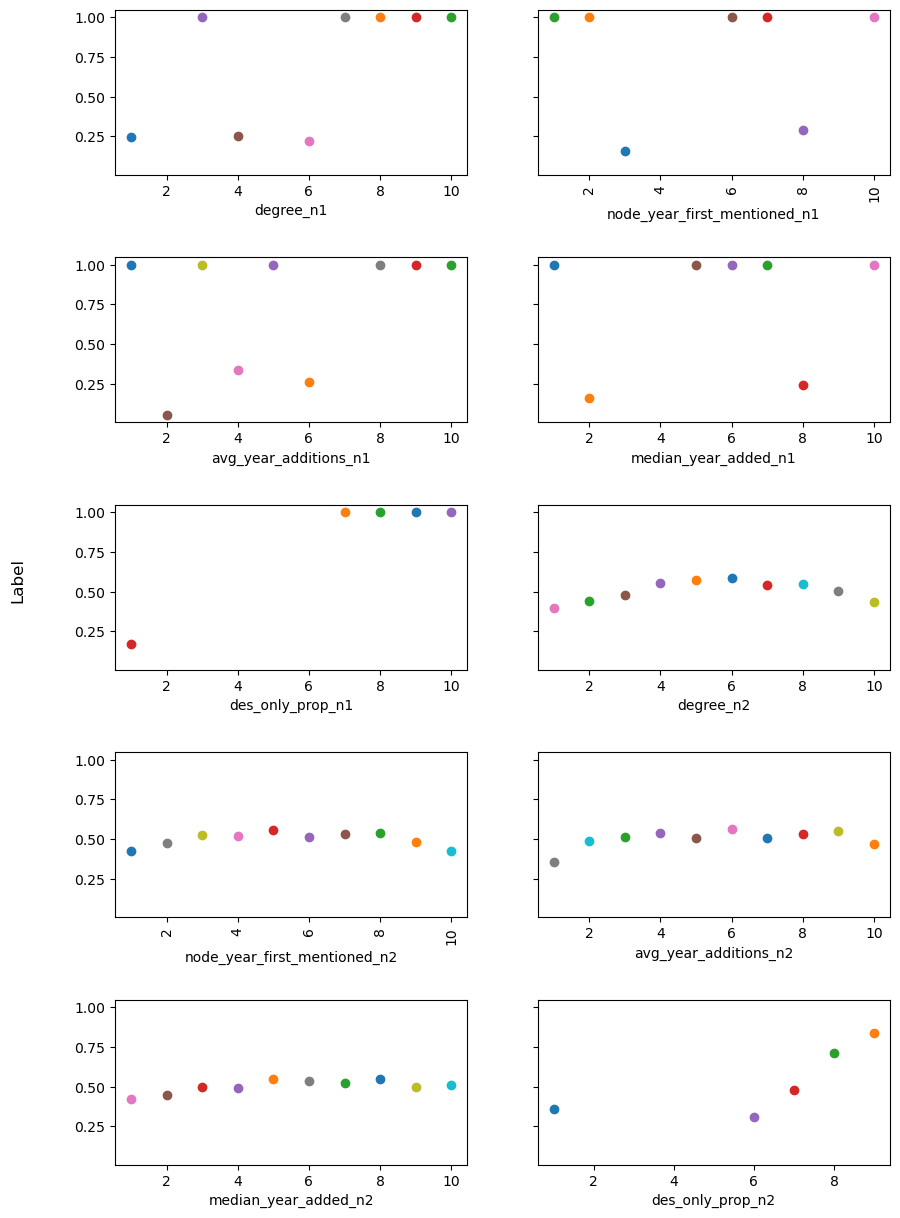

In [122]:
features_to_plot = ['degree_n1', 'node_year_first_mentioned_n1', 'avg_year_additions_n1', 'median_year_added_n1', 'des_only_prop_n1', 'degree_n2', 'node_year_first_mentioned_n2', 'avg_year_additions_n2', 'median_year_added_n2', 'des_only_prop_n2']

fig, axs = plt.subplots(5, 2, figsize=(10, 15), sharey=True)

def get_decile_bin(value, deciles):
    for i, d in enumerate(deciles, start=1):
        if value <= d:
            return i
        
for ax, feature in zip(axs.reshape(-1), features_to_plot):
    deciles = np.percentile(train_df[feature], [10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    bin_assignments = [get_decile_bin(x, deciles) for x in train_df[feature]]
    label_vals = train_df['label'].values.tolist()
    labels_by_bin = defaultdict(list)
    for bin_n, lab_val in zip(bin_assignments, label_vals):
        labels_by_bin[bin_n].append(lab_val)
    for bin_n, label_vals in labels_by_bin.items():
        ax.scatter(bin_n, mean(label_vals))
        ax.set_xlabel(feature)
    if 'node_year_first_mentioned' in feature:
        for tick in ax.get_xticklabels():
            tick.set_rotation(90)
fig.subplots_adjust(hspace=0.5)
fig.supylabel('Label')

Doesn't really look like any of these features are informative on their own. However, we intended them to be informative together -- let's take a look at the correlations between some of their combinations and the resulting labels. We won't be able to exhaustively explore all combinations, but the RF model we train below is designed to exploit feature interactions, so it will likely find interactions that we don't think to look at here.

In [75]:
base_features = ['degree', 'node_year_first_mentioned', 'avg_year_additions', 'median_year_added', 'des_only_prop']

Text(0.02, 0.5, 'Label')

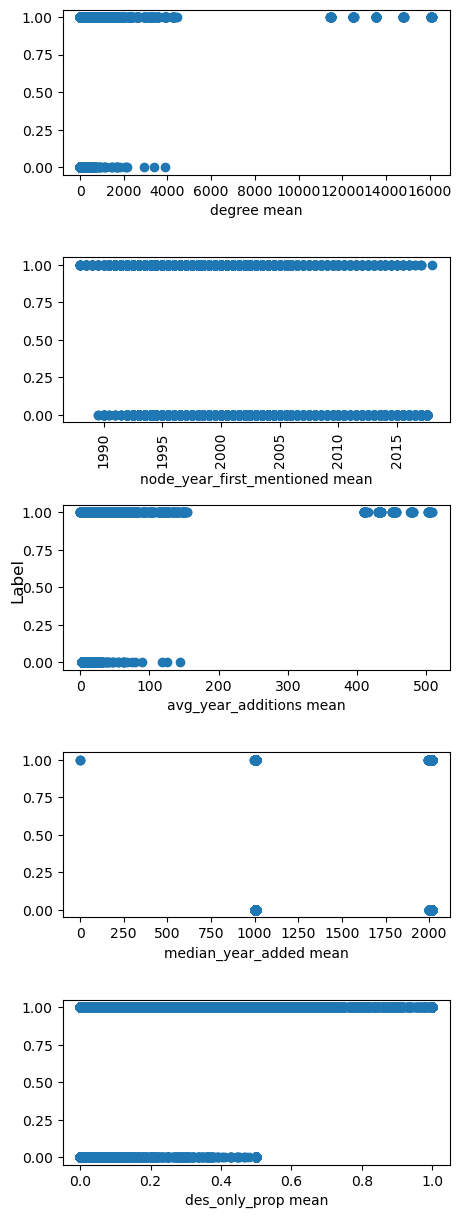

In [76]:
fig, axs = plt.subplots(5, 1, figsize=(5, 15), sharey=True)

for ax, feature in zip(axs.reshape(-1), base_features):
    
    sub = train_df[[f'{feature}_n1', f'{feature}_n2']].astype('float64')
    combined_mean = sub.mean(axis=1)
    ax.scatter(combined_mean, train_df['label'])
    ax.set_xlabel(f'{feature} mean')
    if 'node_year_first_mentioned' in feature:
        for tick in ax.get_xticklabels():
            tick.set_rotation(90)
fig.subplots_adjust(hspace=0.5)
fig.supylabel('Label')

There is definitely some separation between the classes here! Now let's build the RF model and see how we do.

## Machine learning implementation
We're going to start simple, with a RF classifier.

In [77]:
X_train = train_df.drop(columns=['label', 'year'])
y_train = train_df['label']
X_test = test_df.drop(columns=['label', 'year'])
y_test = test_df['label']

In [78]:
# Cast entity types to integers
ent_types = set([attrs['ent_type'] for n, attrs in graph.nodes(data=True)])
ent2int = {et: i for i, et in enumerate(ent_types)}
X_train = X_train.replace({'ent_type_n1': ent2int, 'ent_type_n2': ent2int})
X_test = X_test.replace({'ent_type_n1': ent2int, 'ent_type_n2': ent2int})

In [93]:
# Define the classifier
rf = RandomForestClassifier()

In [100]:
# Set up random search
# Initial setup from https://www.datacamp.com/tutorial/random-forests-classifier-python
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}
rand_search = RandomizedSearchCV(rf,
                                 scoring='precision',
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

In [101]:
# Fit the model
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x2ae1165276d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x2ae0abefc280>},
                   scoring='precision')

In [102]:
# Get the best classifier
best_rf = rand_search.best_estimator_
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 10, 'n_estimators': 131}


In [103]:
# Evaluate
y_pred = best_rf.predict(X_test)

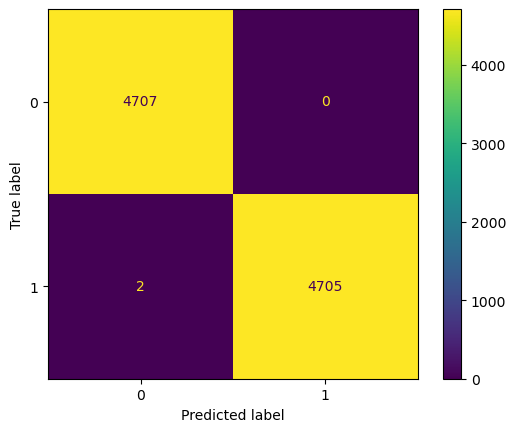

In [104]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [105]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

Accuracy: 0.9997875504567665
Precision: 1.0
Recall: 0.9995751009135331
F1: 0.9997875053123672
